# DEVOIR N°2


Vous devez compresser le dossier contenant vos réponses et le nommer par Your_Name_FirstName.zip et envoyez-le à mon adresse gamil: red.ezzahir 


Vous devez également remettre le devoir en format papier 

# Question 1 (5pts)

Décrire en 30 lignes maximum le principe des algorithmes génétiques ?
vous pour insert 4 images au maximum (voir en bas comment l'image est inserée)

L’Algorithme Génétique est un algorithme d’optimisation qui s’inspire du processus d’évolution des êtres vivants (coucou 👋 les dinosaures 🦕). Il fut développé par le scientifique américain John Henry Holland dans les années 1970.
<img src="dna-Genetic-Algorithm.webp" width="400" height="340">

. L’Algorithme Génétique se base au départ sur une population de solutions candidates appelées parfois individus,              créatures, phénotypes qui va évoluer de génération en génération jusqu’à la génération qui contient les meilleures solutions.

. Chaque individu comprend des propriétés et il peut être sujet à des transformations génétiques (mutation, croisement par exemple).

. Chaque individu est évalué et cette valeur d’aptitude (fitness value) est un critère pour sa survie d’une génération à une autre.

<img src="Schema_simple_algorithme_genetique.png" width="250" height="240">


Le code de ce devoir s'appuie sur la mise en œuvre que nous avons vue lors de travaux pratiques sur les algorithmes génétiques

In [1]:
from random import choices, choice, randint, randrange, shuffle, sample
from random import random as rnd
from typing import List, Optional, Callable, Tuple, Set
from copy import  deepcopy
from functools import partial,   reduce
import statistics as st
import time 
from contextlib import contextmanager
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Genome = List[int]
Chromosome = List[int] 
Population = List[Chromosome]
PopulateFunc = Callable[[], Population]
FitnessFunc = Callable[[Chromosome], int]
SelectionFunc = Callable[[Population, FitnessFunc], Tuple[Chromosome, Chromosome]]
CrossoverFunc = Callable[[Chromosome, Chromosome], Tuple[Chromosome, Chromosome]]
MutationFunc = Callable[[Chromosome], Chromosome]
PrinterFunc = Callable[[Population, int, FitnessFunc], None]



def generate_chromosome(genome: Genome,  chromosome_length=None) -> Chromosome:
    if  chromosome_length is None: 
        return choices(genome, k=len(genome))
    else:
        return choices(genome, k=chromosome_length)


def generate_population (size: int, genome: Genome,  chromosome_length=None ) -> Population: 
    population = []
    i = 0
    while len(population) < size:
        chromosome = generate_chromosome(genome, chromosome_length)
        if not chromosome in population or i == 10: 
            population.append(chromosome)
            i = 0
        else :
            i +=1
        
    return population



def single_point_crossover(a: Chromosome, b: Chromosome) -> Tuple[Chromosome, Chromosome]:
    if not len(a)==len(b):
        raise ValueError("The given chromosones don't have the same length!")
    r = randint(1, len(a)-1)  
    x, y = a.copy(), b.copy()  
    for i in range(r):
        x[i], y[i] = y[i], x[i]
    return x, y
        

def mutation(chromosome: Chromosome, genome: Genome, 
             probability: float = 0.2) -> Chromosome:
    """Mutate, usually with a low probability, the given chromosome. 
     @param chromosome: chromosome to mutate
     @param probability: probability that a mutation attempt will be successful
    """
    chromosome  = chromosome.copy() 
    r = rnd() 
    if r < probability:
        p = randrange(0, len(chromosome))
        x = choice(genome)
        while(x == chromosome[p]):
            x = choice(genome)
        
        chromosome[p]=x
    
    return chromosome


def population_fitness(population: Population, fitness_func: FitnessFunc) -> int:
    return reduce(lambda x, y: x+y, map(fitness_func, population))


def selection_pair(population: Population, fitness_func: FitnessFunc, maximize: bool = False) -> Population:
    fitnesses= list(map(fitness_func, population))
    return  choices(population = population, weights=[fitness_func(gene) for gene in population],  k=2)
        

#help(sorted)
def sort_population(population: Population, 
                    fitness_func: FitnessFunc, 
                    maximize: bool=False) -> Population:
    return sorted(population, key = fitness_func, reverse=maximize)
    

def chromosome_to_string(chromosome: Chromosome) -> str:
    return ''.join(map(str,chromosome))


def print_statistics(population: Population, generation_id: int,  fitness_func: FitnessFunc):
    
    #print("GENERATION %02d" % generation_id)
    #print("=================")
    #print("Population: [%s]" % ", ".join([chromosome_to_string(ch) for ch in population]))
    

    fitness = list(map(fitness_func, population))
    
    #print("  Min %s" % min(fitness))
    #print("  Max %s" % max(fitness))
    #print("  Avg %s" % mean(fitness))
    #print("  Std %s" % stdev(fitness))

     
        
def get_statistics(population: Population, generation_id: int,  fitness_func: FitnessFunc):  
    fitness = list(map(fitness_func, population)) 
    return generation_id,  min(fitness),  max(fitness),  st.mean(fitness), st.stdev(fitness)

     
    
def run_evolution(populate_func: PopulateFunc, fitness_func: FitnessFunc, 
                  fitness_limit: int, maximize: bool = False,
                  selection_func: SelectionFunc = selection_pair,
                  crossover_func: CrossoverFunc = single_point_crossover,
                  mutation_func: MutationFunc = mutation, generation_limit: int = 100,
                  printer: Optional[PrinterFunc] = None) -> Tuple[Population, int]:  
    
    #generate a population initial
    population = populate_func()
    # sort and assign the population 
    population = sort_population(population, fitness_func, maximize)
    # iterate until the generation_limit
    for i in range(generation_limit) : 
        # print the i^th generation if a printer is given
        if not printer is None:
            printer(population, i, fitness_func)
        
        # we break if the fitness_limit is reached, >=fitness_limit when maximization and <=fitness_limit for minimizatio
        best_fitness =fitness_func(population[0])
        if (maximize and best_fitness >= fitness_limit) \
                or (not maximize and best_fitness <= fitness_limit):
            break;
             
        # initialize next_generation by the two first individuals in the sorted population
        next_generation = [population[0], population[1]]
        while len(next_generation) < len(population): 
            # select  a pair of parents  uning selection_func and fitness_func 
            x, y = selection_func(population, fitness_func, maximize) 
            # call crossover_func to get offspring a, b from the parents
            a, b = crossover_func(x, y)
            # apply  mutation_func on each offspring 
            a = mutation_func(a)
            b = mutation_func(b)
            # increment the next generation 
            next_generation.append(a)
            next_generation.append(b)
            

        # population = next_generation
        population = next_generation
        # sort and assign the population 
        population = sort_population(population, fitness_func, maximize) 
        
    printer(population, i, fitness_func)
    best_fitness =fitness_func(population[0])
 
    return population, best_fitness, i
 
@contextmanager
def timer():
    start=time.time()
    yield
    end=time.time()
    global elapsed_time
    elapsed_time= end - start


# Question 2 (3pts)
Dans ce problème, une fonction présentant plusieurs maxima locaux (ce qui rend inapplicables les algorithmes les plus simples de recherche de maximum) est définie sur un certain intervalle et le but est de déterminer à l'aide des algorithmes génétiques l'abscisse du maximum global (sur l'intervalle) de la fonction. On va donc utiliser une population dans laquelle chaque individu correspond à une abscisse située dans l'intervalle.

La fonction $g(x) =x^2cos(1/(10x))sin(x/10)/10$ à optimiser est présentée dans la figure suivante:



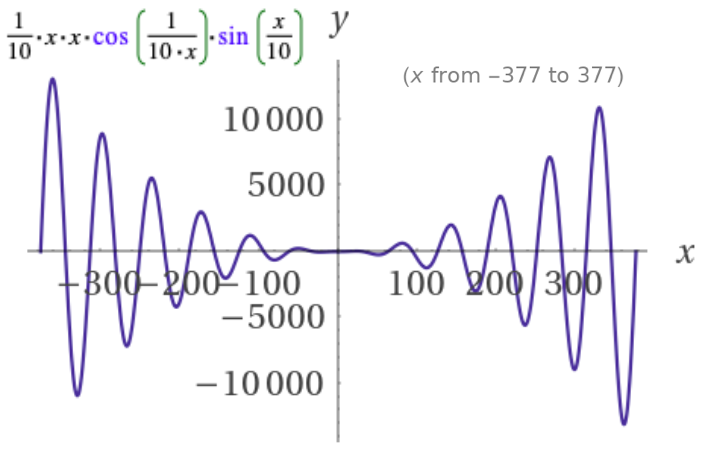

### Remarque :

l’étude d’une fonction à une variable n’a pour but uniquement la démonstration pédagogique et illustratif, puisque vous constaterez que le nombre total d'abscisses testées avant d'atteindre le maximum global (égal au nombre de générations multiplié par la taille de la  population) est généralement tel qu'on aurait un aussi bon résultat en répartissant simplement ce nombre d'abscisses uniformément sur l'intervalle puis en cherchant Max(f(Xi)). L'intérêt des algorithmes génétiques pour la recherche de maximum de fonction n'est en pratique réel que dans le cas d'une fonction à beaucoup de variables, car alors toute exploration systématique de l'espace des n-uplets possibles devient prohibitive, tandis qu'un algorithme génétique peut rester efficace. Malheureusement, la visualisation de la recherche du maximum d'une fonction à n variables est problématique pour n=2, et devient carrément impossible (ou en tout cas incompréhensible) pour n>=3...


### Codage du Chromosome

Une des premières questions qui se posent est celle du codage : à quelle séquence de gènes faire correspondre une abscisse de l'intervalle ? On peut faire le choix de prendre chaque gène égal à un bit (donc le génome original est 01), et de faire correspondre à chaque chromosome  (du type 10011100...) l'abscisse 
$x = xMin + N*(xMax - xMin)/Nmax $
où N est l'entier dont la représentation binaire est donnée par le chromosome, et Nmax est le plus grand entier représentable avec le nombre de bits correspondant à taille du chromosome. Il ne reste donc plus qu'à choisir le nombre de bits constituant le génome de chaque individu. 
 Nous nous intéressons à optimiser la fonction g(x) dans l’intervalle $I=[-255, 255]$.
 

### 2.1) Que représentent  xMin, et xMax.
 

In [2]:
xMin, xMax =  -255, 255


### 2.2)  Taille du chromosome 
Si la taille du chromosome est n bits,  donner  Nmax en fonction de n (noté bien que pour  8 bits =>  Nmax=256), puis déduire le nombre minimal de bits (n_min) constituant le chromosome de chaque individu pour pouvoir representer 8 individus entre chaque deux entiers de l’interval I (Le nombre total d'individus representable est donc (xMax - xMin)*8).


In [3]:
#return the maximum integer to represent by n bits ()
def n_max(n) :
    return  2**n - 1

#return the minimum nomber of bits to represent N 
def n_bits(N):
    return N.bit_length()

    
n_min =  n_bits((xMax - xMin)*8)  

Nmax =  n_max(n_min) 

print("nmin = ",n_min)

print('Nmax=', Nmax)




nmin =  12
Nmax= 4095


# Question 3 (3pts)
#### MAXIMIZING g(x) =x^2/10 cos(1/(10x))sin(x/10) USING GENETIC ALGORITHM 

##### 3.1) Ecrire la fonction genome_gx que retourne un genome composé de deux gènes 0 et 1

In [4]:
def genome_gx() -> Genome:
    return [0,1]

#### 3.2) En utilisant l'opérateur de décalage de bits +| ecrire la fonction qui convertie un chromosome  (liste binaire) en entier.


In [5]:
def chromosome_to_integer(chromosome: Chromosome):
    n=0
    for i,j in enumerate(reversed(chromosome)):
        n |= j << i
    return n    

In [6]:
genome = genome_gx()
chromosome= generate_chromosome(genome,chromosome_length=11)
print("chromosome: ",chromosome)
print("chromosome to integer: ",chromosome_to_integer(chromosome))

chromosome:  [0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1]
chromosome to integer:  715


#### 3.3) En utilisant la fonction précedente ecrire une fonction qui transforme un chromosome en un individus x (abscisse) $x = xMin + N*(xMax - xMin)/Nmax $, ou N est l'entier représenté par le chromosome.

In [7]:
def chromosome_to_x(chromosome: Chromosome):
     return xMin + chromosome_to_integer(chromosome)*(xMax-xMin)/Nmax

In [8]:
chromosome_to_x(chromosome)

-165.95238095238096

#### 3.4) En utilisant la fonction précedente ecrire la fonction gx qui retourne l'évaluation d'un chromosome par la fonction $g(x) =x^2cos(1/(10x))sin(x/10)/10$ 

In [9]:
def gx(chromosome: Chromosome):
    x = chromosome_to_x(chromosome)
    if x == 0:
        return 0
    return x**2 * np.cos(1/(10*x)) * np.sin(x/10) / 10

#### 3.5) En utilisant le moteur de recherche de google  (ecrire dans le champs de recherche l'expression x*x cos(1/(10x))sin(x/10)/10 ) verifier que la valeur minimale de g dans l'intervale $I$ est $-5555$ et mettre le boolean à True si oui.

In [10]:
verified = True

#### 3.6)  Ecrire la fonction fitenss_gx  qui retourne  (gx(chromosone) + 5555)/100

In [11]:
def fitness_gx(chromosome: Chromosome):
    # use the functions above
    y=gx(chromosome)
    return (y + 5555)/10

#### 3.7)  Expliquer pourquoi nous avons ajouté 5555 à gx et pour quel raison nous avons divisé par 100

Puisque -5555 est la valeur minimale de g, donc nous avons ajouté 5555 pour avoir des valeurs postitives, puis nous avons divisé par 100 pour obtenir un pourcentage(un poids).

#### 3.8) Quelle est la valeur max du fitness_gx  (FITNESS_LIMIT ) si le max de g(x) dans I est 5555

In [12]:
FITNESS_LIMIT = (5555+5555)/10
FITNESS_LIMIT

1111.0

#### 3.9) C'est le temps de tester l'agorithme genetique sur g(x) 

In [13]:
POPULATION_SIZE = 6
MUTATION_RATE = 0.15
GENERATION_LIMIT =  1000



In [14]:
def run_genetic(): 
    with timer():
        population, best_f, generations =  run_evolution(
                populate_func=partial(generate_population, size=POPULATION_SIZE, genome=genome_gx(), chromosome_length=n_bits(Nmax)),
                fitness_func=fitness_gx, mutation_func=partial(mutation, genome=genome_gx(), probability=MUTATION_RATE),
                fitness_limit=FITNESS_LIMIT, crossover_func=single_point_crossover,
                printer=print_statistics, maximize=True,
                generation_limit=GENERATION_LIMIT) 
    #end = time.time() 
    #elapsed_time=(end - start)
    generation_id,  min_fit ,  max_fit ,  avg_fit , stdev_fit  = \
                                    get_statistics(population, generations, fitness_func=fitness_gx )
    
    return chromosome_to_x(population[0]), min_fit, stdev_fit,  max_fit, avg_fit, generation_id,  elapsed_time


x,  min_fit, stdev_fit,  max_fit, avg_fit,  gen_i, t = run_genetic()
print("x qui maximise g {:.2f}".format(x))
print("g( {:.2f} )= {:.2f}".format(x, (x * x * np.cos(1 / (10. * x)) * np.sin(x / 10.) / 10.)))
print("fitness de x : {:.2f}".format(max_fit))
print("nombre de generations:", gen_i)
print("la moyen des fitness de la generation ", gen_i, " est {:.2f}".format(avg_fit))
print("Le temps d'execution est  {:.3f}".format(t))


x qui maximise g -239.18
g( -239.18 )= 5361.41
fitness de x : 1091.64
nombre de generations: 999
la moyen des fitness de la generation  999  est 1090.97
Le temps d'execution est  0.274


# Question 4 (3pts)

L'impact du nombre d'individus de la population sur la convergence:
si celui-ci est trop petit, il faut beaucoup plus de générations pour atteindre le maximum, car il n'y a pas assez de variété dans la population initiale, et seules les mutations finissent par permettre à l'algorithme de converger.

En suivant le schema suivant (Même principe utilié en devoir pour collecter et plotter des résultats) :

Initialisez un Tableau des resultats  (Results)

Pour POPULATION_SIZE allons de 2 jusqu'à 20 faire

    pour i alons de 1 jusqu'à 100 faire
        executez la fonction run_genetic() 
        les resultats sont collecter dans une liste 
    
    calculez les moyennes sur les 100 executions uiliser le module statistic vois plus haut
    et sauvgardez les dans le Tableau Results
    
Tracer les courbes des resultats (fitness, avg_fitness, generations, temps) en fonction de POPULATION_SIZE

Note: fitness et avg_fitness pouvent être tracées sur la même figure.

Commentez les courbes.



In [15]:

import time 
Results=[]
Results_x=[]
Results_mean=[]
for pop_size in range(2,21):
    POPULATION_SIZE = pop_size
    for i in range(1,5):
        Results.append(run_genetic())
    
    for j in Results:
          Results_x.append(j[3:])
    df=pd.DataFrame(Results_x, columns=["fitness" , "avg_fitness" , "generation" , "time"])
    
    Results_mean.append([st.mean(df[c]) for c in df.columns])
    
df_mean=pd.DataFrame(Results_mean,columns=["mean_fitness" , "mean_avg_fitness" , "mean_generation" , "mean_time"],index=range(2,21))

In [16]:
df_mean.index.name="Pop_Size"
df_mean

,mean_fitness,mean_avg_fitness,mean_generation,mean_time
Pop_Size,,,,
2,584.382020,466.511206,999.000000,0.036153
3,744.619747,662.926787,927.000000,0.056682
4,814.111248,745.928354,927.000000,0.072100
5,856.852841,794.129519,934.200000,0.097116
6,885.160870,823.853003,925.316667,0.114379
7,905.805984,847.519734,919.535714,0.137039
8,920.365930,864.278286,910.616071,0.158381
9,933.907374,877.774276,898.305556,0.181605
10,946.057889,890.236666,882.850000,0.200708


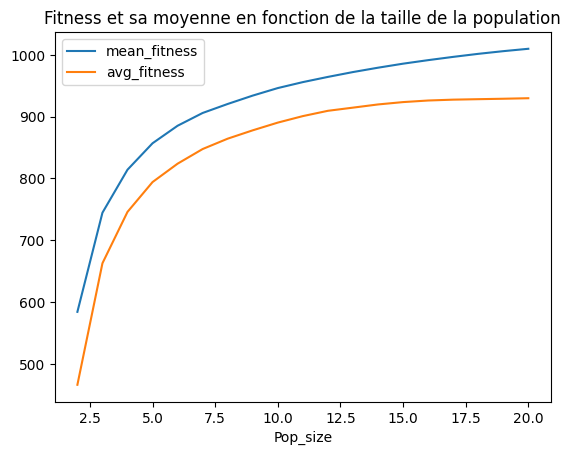

In [17]:
fitness = df_mean['mean_fitness']
avg_fitness = df_mean['mean_avg_fitness']
generations = df_mean['mean_generation']
time = df_mean['mean_time']

population = list(range(2,21))

plt.plot(population,fitness,label = 'mean_fitness')
plt.plot(population,avg_fitness,label = 'avg_fitness')
plt.title("Fitness et sa moyenne en fonction de la taille de la population")
plt.xlabel("Pop_size")
plt.savefig('Fitness_pop.png', dpi=300, bbox_inches='tight')
plt.legend()
plt.show()

### $\color{Orange}{\text{Conclusion}}$
On remarque que la moyenne de fitness est  proportionnelle à la moyenne de  avg_fitness, si la population augmente la moyenne de fitness augmente sans jamais dépasser la limite 1111.


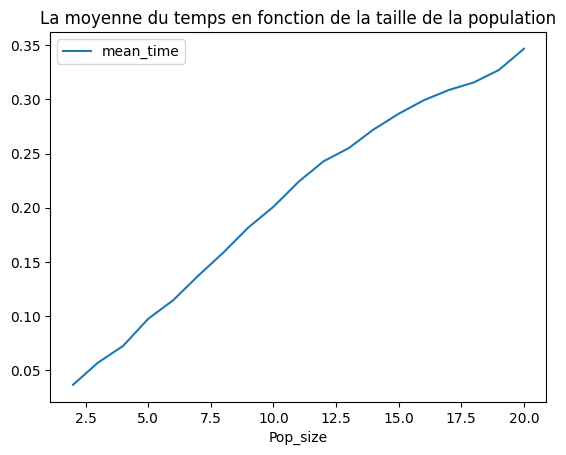

In [18]:
plt.plot(population,time,label = 'mean_time')
plt.title("La moyenne du temps en fonction de la taille de la population")
plt.savefig('Time_pop.png', dpi=300, bbox_inches='tight')
plt.xlabel("Pop_size")
plt.legend()
plt.show()

### $\color{Blue}{\text{Conclusion}}$

On remarque que le temps d'éxecution augmente avec la taille de la population, ce qui est évident car l'algorithme génetique prends beaucoup plus de temps lorsque la population est grande.

# Question 5 (3pts)


L'influence de la taille du chromosome : si elle est trop faible, l'algorithme est susceptible de se bloquer dans un maximum local au lieu de converger vers le maximum global.

En suivant le même schema mais en fixant POPULATION_SIZE à la bonne valueur déduite de la question précedente (le cas écheant utiliser POPULATION_SIZE=6), et en variant 
Nmax sur [16, 32, 64, 128, 255, 1024, 2047]

Tracer les courbes des resultats (fitness, avg_fitness, generations, temps) en fonction de n_bits(Nmax)

Note: fitness et avg_fitness pouvent être ploté sur la même figure.

Commentez les courbes.




In [19]:
import time 
Results=[]
Results_x=[]
Results_mean=[]
POPULATION_SIZE = 6
for i in [15,31,63,255,1023,2047,4095]:
    Nmax = i
    for i in range(1,11):
        Results.append(run_genetic())

    for j in Results:
          Results_x.append(j[3:])
    df1=pd.DataFrame(Results_x, columns=["fitness" , "avg_fitness" , "generation" , "time"])
    
    Results_mean.append([st.mean(df1[c]) for c in df1.columns])

df_mean1=pd.DataFrame(Results_mean,columns=["mean_fitness" , "mean_avg_fitness" , "mean_generation" , "mean_time"],index=[15,31,63,255,1023,2047,4095])

In [20]:
df_mean1

,mean_fitness,mean_avg_fitness,mean_generation,mean_time
15,788.977677,761.438443,999.000000,0.234175
31,875.917151,831.875376,999.000000,0.250497
63,918.865031,872.442625,999.000000,0.253556
255,946.924625,896.394597,941.930000,0.240178
1023,965.226324,914.895658,900.400000,0.230444
2047,977.880372,927.439416,876.966667,0.225388
4095,988.139317,937.586949,855.428571,0.220991


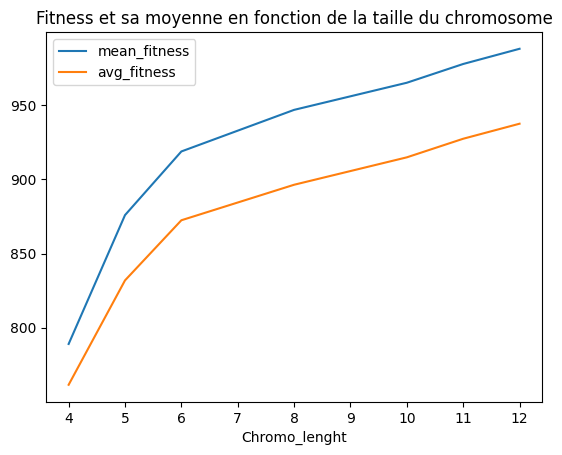

In [21]:
nbits=[]
for i in [15,31,63,255,1023,2047,4095]:
    nbits.append(n_bits(i))
fitness = df_mean1['mean_fitness']    
avg_fitness = df_mean1['mean_avg_fitness']
generations = df_mean1['mean_generation']
time = df_mean1['mean_time']    
plt.plot(nbits,fitness,label = 'mean_fitness')
plt.plot(nbits,avg_fitness,label = 'avg_fitness')
plt.title("Fitness et sa moyenne en fonction de la taille du chromosome")
plt.savefig('Fitness_chrom.png', dpi=300, bbox_inches='tight')
plt.xlabel("Chromo_lenght")

plt.legend()
plt.show()    
    

### $\color{orange}{\text{Conclusion}}$

On remarque que la moyenne de fitness est proportionnelle à la moyenne de avg_fitness, si la taille des chromosomes augmente la moyenne de fitness augmente sans jamais dépasser la limite 1111.


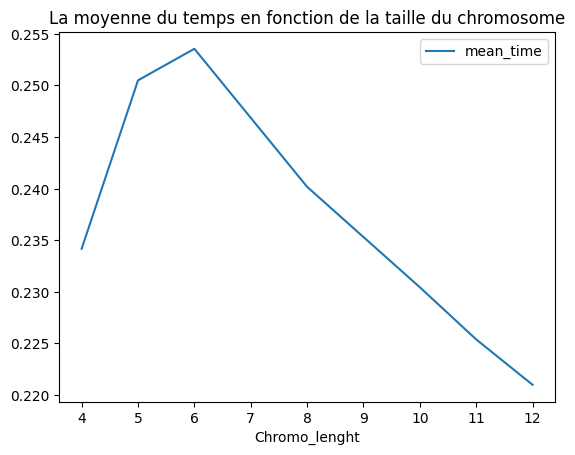

In [22]:
plt.plot(nbits,time,label = 'mean_time')
plt.title("La moyenne du temps en fonction de la taille du chromosome")
plt.savefig('Time_chrom.png', dpi=300, bbox_inches='tight')
plt.xlabel("Chromo_lenght")
plt.legend()
plt.show()    

# Question 6 (2pts)

#### MINIMIZING g(x) =x^2/10 cos(1/(10x))sin(x/10) USING GENETIC ALGORITHM 
reécrire les codes de la question 3 pour lancer un teste de minimization de g(x)

In [23]:
FITNESS_LIMIT = 0
def fitness_gx(chromosome: Chromosome):
    # use the functions above
    y=gx(chromosome)
    return (y +5555)/10

In [24]:
import time
def run_genetic(): 
    with timer():
        population, best_f, generations =  run_evolution(
                populate_func=partial(generate_population, size=POPULATION_SIZE, genome=genome_gx(), chromosome_length=n_bits(Nmax)),
                fitness_func=fitness_gx, mutation_func=partial(mutation, genome=genome_gx(), probability=MUTATION_RATE),
                fitness_limit=FITNESS_LIMIT, crossover_func=single_point_crossover,
                printer=print_statistics, maximize=False,
                generation_limit=GENERATION_LIMIT) 

    generation_id,  min_fit ,  max_fit ,  avg_fit , stdev_fit  = \
                                    get_statistics(population, generations, fitness_func=fitness_gx )
    
    return chromosome_to_x(population[0]), min_fit, stdev_fit,  max_fit, avg_fit, generation_id,  elapsed_time


x,  min_fit, stdev_fit,  max_fit, avg_fit,  gen_i, t = run_genetic()
print("x qui minimise g {:.2f}".format(x))
print("g( {:.2f} )= {:.2f}".format(x, (x * x * np.cos(1 / (10. * x)) * np.sin(x / 10.) / 10.)))
print("fitness de x : {:.2f}".format(max_fit))
print("nombre de generations:", gen_i)
print("la moyen des fitness de la generation ", gen_i, " est {:.2f}".format(avg_fit))
print("Le temps d'execution est  {:.3f}".format(t))


x qui minimise g 236.69
g( 236.69 )= -5570.11
fitness de x : 974.20
nombre de generations: 120
la moyen des fitness de la generation  120  est 487.40
Le temps d'execution est  0.035
